### Initial settings

In [1]:
#-- Import general libraries
import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices # Comment out this line if runing on GPU cluster
import numpy as np 
import pandas as pd
import time 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import wandb

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{2}"

In [3]:
# Check if GPU is available 
is_gpu = torch.cuda.is_available()
device = torch.device("cuda" if is_gpu else "cpu")
print(f"Is GPU available? {is_gpu}")

# If GPU is available, print additional information
if is_gpu:
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"GPU Device Name: {device_name}")
    print(f"GPU Device Index: {current_device}")

Is GPU available? True
GPU Device Name: GeForce RTX 2080 Ti
GPU Device Index: 0


#### Filters

In [4]:
# # # ################################### # # #
# # # ######   Numerial parameters ###### # # #
# # # ################################### # # #
c = 1  # speed of sound 1m/s
courant_number = 0.1

# # # ################################### # # #
# # # ######    Linear Filter      ###### # # #
# # # ################################### # # #




filter = torch.tensor([[0.0, -1.0, 0.0],
       [-1.0, 4.0, -1.0],
       [0.0, -1.0, 0.0]])



advection_operator_x = torch.tensor([[0.0, 0.0, 0.0],
       [0.5, 0.0, -0.5],
       [0.0, 0.0, 0.0]])

advection_operator_y = torch.tensor([[0.0, -0.5, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.5, 0.0]])

print(filter)
print(filter.shape)

tensor([[ 0., -1.,  0.],
        [-1.,  4., -1.],
        [ 0., -1.,  0.]])
torch.Size([3, 3])


##### 7*7 Cubic

In [5]:
# 7*7
data_str = """-1.0975826519729831E-003   6.6388197653750505E-003  -3.1874333451830800E-002   4.1414859580519367E-003  -3.1874333451830786E-002   6.6388197653750435E-003  -1.0975826519729816E-003
 6.6388197653750505E-003  -3.4553857092072565E-002  0.13605581230003569       0.18684678279416977       0.13605581230003563       -3.4553857092072537E-002   6.6388197653750418E-003
-3.1874333451830800E-002  0.13605581230003572      -0.35093761109136207       -2.0260398151439736      -0.35093761109136201       0.13605581230003563       -3.1874333451830779E-002
 4.1414859580518951E-003  0.18684678279416983       -2.0260398151439745        8.0000000000000000       -2.0260398151439745       0.18684678279416983        4.1414859580518951E-003
-3.1874333451830786E-002  0.13605581230003563      -0.35093761109136201       -2.0260398151439736      -0.35093761109136201       0.13605581230003569       -3.1874333451830800E-002
 6.6388197653750418E-003  -3.4553857092072537E-002  0.13605581230003563       0.18684678279416977       0.13605581230003566       -3.4553857092072565E-002   6.6388197653750505E-003
-1.0975826519729816E-003   6.6388197653750435E-003  -3.1874333451830779E-002   4.1414859580519367E-003  -3.1874333451830807E-002   6.6388197653750505E-003  -1.0975826519729831E-003"""

# Convert the string to a 2D NumPy array
data_array = np.array([list(map(float, line.split())) for line in data_str.split('\n')])

# Reshape the array into a 9x9 tensor
tensor = data_array.reshape(7, 7)

# Print the generated tensor
print(tensor)

filter = torch.FloatTensor(tensor*1)

print(filter.shape)

[[-1.09758265e-03  6.63881977e-03 -3.18743335e-02  4.14148596e-03
  -3.18743335e-02  6.63881977e-03 -1.09758265e-03]
 [ 6.63881977e-03 -3.45538571e-02  1.36055812e-01  1.86846783e-01
   1.36055812e-01 -3.45538571e-02  6.63881977e-03]
 [-3.18743335e-02  1.36055812e-01 -3.50937611e-01 -2.02603982e+00
  -3.50937611e-01  1.36055812e-01 -3.18743335e-02]
 [ 4.14148596e-03  1.86846783e-01 -2.02603982e+00  8.00000000e+00
  -2.02603982e+00  1.86846783e-01  4.14148596e-03]
 [-3.18743335e-02  1.36055812e-01 -3.50937611e-01 -2.02603982e+00
  -3.50937611e-01  1.36055812e-01 -3.18743335e-02]
 [ 6.63881977e-03 -3.45538571e-02  1.36055812e-01  1.86846783e-01
   1.36055812e-01 -3.45538571e-02  6.63881977e-03]
 [-1.09758265e-03  6.63881977e-03 -3.18743335e-02  4.14148596e-03
  -3.18743335e-02  6.63881977e-03 -1.09758265e-03]]
torch.Size([7, 7])


#### New initial conditions - Gaussian Distribution

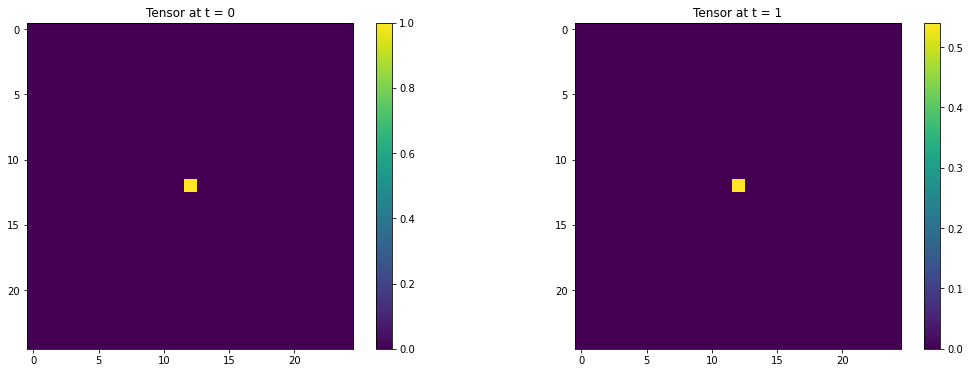

In [6]:
# Specify the size of the tensor
xysize = 25

# Create a meshgrid
x_values = np.linspace(0, 1, xysize)
y_values = np.linspace(0, 1, xysize)
x, y = np.meshgrid(x_values, y_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Equation parameters
sqrt2 = np.sqrt(2)
pi = np.pi

# Define the time tensors for t = 0, 1, and 2
time_tensor_t0 = torch.tensor(0, dtype=torch.float32)
time_tensor_t1 = torch.tensor(1, dtype=torch.float32)

# Function to create 2D Gaussian distribution
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
    return torch.exp(exponent)

# Parameters for Gaussian distributions
mu_x = 0.5
mu_y = 0.5
sigma_x = 0.005
sigma_y = 0.005

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# Stack the tensors along a new dimension to create 3D tensors
status_t0 = t0_values
status_t1 = t1_values

# Plot the tensors
plt.figure(figsize=(18, 6))

# Plot at t = 0
plt.subplot(1, 2, 1)
plt.imshow(status_t0.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 0')
plt.colorbar()

# Plot at t = 1
plt.subplot(1, 2, 2)
plt.imshow(status_t1.numpy(), cmap='viridis', interpolation='none')
plt.title('Tensor at t = 1')
plt.colorbar()

# # Plot at t = 2
# plt.subplot(1, 3, 3)
# plt.imshow(status_t2.numpy(), cmap='viridis', interpolation='none')
# plt.title('Tensor at t = 2')
# plt.colorbar()

plt.show()

#### C spead of sound

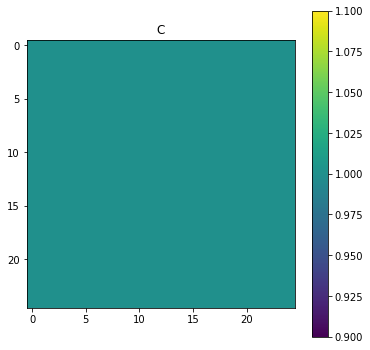

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

In [7]:
c_np = np.ones((xysize, xysize))

# uncomment to make the values different
# right_half_start = xysize // 2
# c_np[:, right_half_start:] = 2

c = torch.from_numpy(c_np).float().requires_grad_()

# Plot the tensor at t = 0
plt.figure(figsize=(6, 6))
plt.imshow(c.detach().numpy(), cmap='viridis', interpolation='none')
plt.title('C')
plt.colorbar()
plt.show()

c = c.to(device)
print(c)

#### Sigma2

In [8]:
l = xysize/10

In [9]:
value_origin_point = - 9 * (4-0)
k = 400

In [10]:
sigma2 = torch.zeros((xysize, xysize), dtype=torch.float32)

In [11]:
l_over_speed = (l / 1) * 0.05 
print(l_over_speed)

0.125


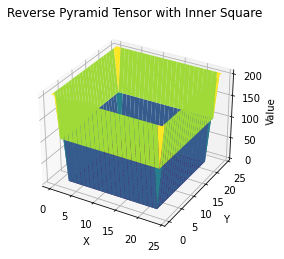

In [12]:
def create_reverse_pyramid_tensor(size, inner_square_ratio):
    pyramid = np.zeros((size, size), dtype=np.float32)

    center = size // 2
    center_value = -16.0/(l_over_speed*l_over_speed)
    boundary_value = 4.0/(l_over_speed*l_over_speed)

    inner_square_width = int(size * inner_square_ratio)

    for i in range(size):
        for j in range(size):
            distance_to_center = max(abs(i - center), abs(j - center))
            
            # Set the values for the reverse pyramid
            pyramid[i, j] = center_value + 4.0/(l_over_speed*l_over_speed) * (distance_to_center/xysize/0.1)
            
            # Set the values for the inner square to 0
            if (
                i >= center - inner_square_width // 2 and i < center + inner_square_width // 2
                and j >= center - inner_square_width // 2 and j < center + inner_square_width // 2
            ):
                pyramid[i, j] = 0.0

    return pyramid

# Set the size of the pyramid (choose an odd number for symmetry)
pyramid_size = 25  # xysize = 25
# inner_square_ratio = 9/10
inner_square_ratio = 4/5

# Create the reverse pyramid tensor with inner square values set to 0
sigma2 = create_reverse_pyramid_tensor(pyramid_size, inner_square_ratio)

# Plot the reverse pyramid tensor
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.arange(0, pyramid_size, 1)
y = np.arange(0, pyramid_size, 1)
x, y = np.meshgrid(x, y)

ax.plot_surface(x, y, sigma2, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Value')
ax.set_title('Reverse Pyramid Tensor with Inner Square')

plt.show()

sigma2 = torch.from_numpy(sigma2).to(device)

tensor([[204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000,
         204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000,
         204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000, 204.8000,
         204.8000, 204.8000, 204.8000, 204.8000],
        [204.8000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000,
         102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000,
         102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000, 102.4000,
         102.4000, 102.4000, 102.4000, 204.8000],
        [204.8000, 102.4000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000, 102.4000, 204.8000],
        [204.8000, 102.4000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  

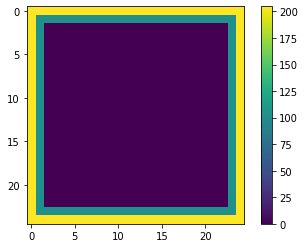

In [13]:
print(sigma2)
plt.imshow(sigma2.detach().cpu().numpy(), cmap='viridis', interpolation='none')
plt.colorbar()

#### ML

In [14]:
ML = torch.ones((1, 1, xysize, xysize), dtype=torch.float64)

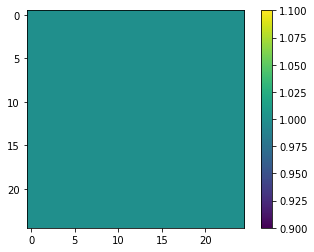

In [15]:
plt.imshow((ML/ML)[0][0].detach().cpu().numpy(), cmap='viridis', interpolation='none')
plt.colorbar()

### Define NN Model

#### Integrated version - one time step

In [16]:
import torch.nn as nn

class AI4WaveNeuralNetwork(nn.Module):
    def __init__(self, xysize, filter_weight):
        super(AI4WaveNeuralNetwork, self).__init__()

        # Specify the size of the input (batch_size, channels, height, width)
        input_size = (1, 1, xysize, xysize)  # Adjust the size based on your requirements
        batch_size, in_channels, height, width = input_size

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]

        padding = (kernel_size - 1) // 2

        # Create a Conv2d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        self.conv_layer.weight.data = filter_weight

        self.xysize = xysize

    def forward(self, status_tn, status_tn_1, c, sigma2):
        # Calculate status_tn1 based on the provided expression
        c_status_tn = c * status_tn

        conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))

        ML = torch.ones_like(status_tn)

        # temp = 100
        temp = sigma2 + 100

        
        status_tn1 = ( ML * (2 * status_tn - status_tn_1) / (0.1 * 0.1) - conv_term/2 ) / (ML * temp)
        # status_tn1 = ((2 * status_tn - status_tn_1) - ((conv_term) * (0.1 * 0.1) / 2)) * ML
        # print(ML.shape)
        
        # status_tn1 = (2 * status_tn - status_tn_1) - ((conv_term) * (0.1 * 0.1) / 2)
        # status_tn1 = sigma2_inv * ((2 * status_tn - status_tn_1)/(0.1*0.1) - (conv_term) / 2)

        # Retain gradients for non-leaf tensors
        c.retain_grad()

        return status_tn1


# Assume xysize, filter, and status_t0 are already defined
xysize = 25  # Replace with your actual value
filter_weight = filter.view(1, 1, filter.shape[0], filter.shape[1]).to(device)  # Assuming filter is a 2D filter
mymodel_onestep = AI4WaveNeuralNetwork(xysize, filter_weight)

# Create a random input tensor for testing
status_t0_tensor = status_t0.view(1, 1, xysize, xysize).to(device)

# Perform a forward pass using AI4WaveNeuralNetwork
status_tn_1_tensor = status_t0.to(device)
c_tensor = c.to(device)

ML = ML.to(device).view(1, 1, xysize, xysize)

output_tensor = mymodel_onestep(status_t0_tensor, status_tn_1_tensor, c_tensor, sigma2) * torch.ones((1, 1, xysize, xysize), dtype=torch.float32).to(device)

# Print the filter weight and the output
print("Filter Weight:")
print(filter_weight)
print("\nOutput Tensor Shape:")
print(output_tensor.shape)

Filter Weight:
tensor([[[[-1.0976e-03,  6.6388e-03, -3.1874e-02,  4.1415e-03, -3.1874e-02,
            6.6388e-03, -1.0976e-03],
          [ 6.6388e-03, -3.4554e-02,  1.3606e-01,  1.8685e-01,  1.3606e-01,
           -3.4554e-02,  6.6388e-03],
          [-3.1874e-02,  1.3606e-01, -3.5094e-01, -2.0260e+00, -3.5094e-01,
            1.3606e-01, -3.1874e-02],
          [ 4.1415e-03,  1.8685e-01, -2.0260e+00,  8.0000e+00, -2.0260e+00,
            1.8685e-01,  4.1415e-03],
          [-3.1874e-02,  1.3606e-01, -3.5094e-01, -2.0260e+00, -3.5094e-01,
            1.3606e-01, -3.1874e-02],
          [ 6.6388e-03, -3.4554e-02,  1.3606e-01,  1.8685e-01,  1.3606e-01,
           -3.4554e-02,  6.6388e-03],
          [-1.0976e-03,  6.6388e-03, -3.1874e-02,  4.1415e-03, -3.1874e-02,
            6.6388e-03, -1.0976e-03]]]], device='cuda:0')

Output Tensor Shape:
torch.Size([1, 1, 25, 25])


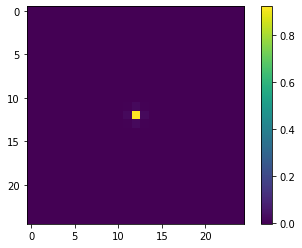

In [17]:
plt.imshow(output_tensor.cpu().detach().numpy()[0][0])
plt.colorbar()

#### one time step - skipping layers

In [18]:
class AI4WaveNeuralNetwork_One_Skipping(nn.Module):
    def __init__(self, xysize, filter_weight):
        super(AI4WaveNeuralNetwork_One_Skipping, self).__init__()

        # Specify the size of the input (batch_size, channels, height, width)
        in_channels = 1

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]
        padding = (kernel_size - 1) // 2

        # Create a Conv2d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        self.conv_layer.weight.data = filter_weight

        self.xysize = xysize

    def forward(self, status_tn, status_tn_1, c, sigma2_inv):
        output_list = [status_tn]

        c.retain_grad()

        # Calculate status_tn1 based on the provided expression
        c_status_tn = c * status_tn
        conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
        
        status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
        
        output_list.append(status_tn1)

        output_stacked = torch.cat(output_list, dim=1)

        return output_stacked

#### multi time step - skipping layers

In [19]:
class ConstantCValueLayer(nn.Module):
    def __init__(self, xysize):
        super(ConstantCValueLayer, self).__init__()
        self.xysize = xysize

    def forward(self, c_value):
        c_value.retain_grad()
        c = torch.full((self.xysize, self.xysize), c_value.item(), device=device, requires_grad=True)
        return c

In [20]:
class AI4WaveNeuralNetwork_Multi_Skipping(nn.Module):
    def __init__(self, xysize, filter_weight):
        super(AI4WaveNeuralNetwork_Multi_Skipping, self).__init__()

        # Specify the size of the input (batch_size, channels, height, width)
        in_channels = 1

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]
        padding = (kernel_size - 1) // 2

        # Create a Conv2d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        self.conv_layer.weight.data = filter_weight

        self.constant_layer = ConstantCValueLayer(xysize)

        self.xysize = xysize

    def forward(self, status_tn, status_tn_1, c_value, sigma2_inv, nsteps):
        output_list = [status_tn_1, status_tn]

        # c = self.constant_layer(c_value)
        # c = torch.full((self.xysize, self.xysize), c_value.item(), device=device, requires_grad=True)
        c_ones = torch.ones((self.xysize, self.xysize), device=device, requires_grad=True)
        c = c_value * c_ones

        for i in range(nsteps):
            # Calculate status_tn1 based on the provided expression
            c_status_tn = c * status_tn
            conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
            
            status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
            
            output_list.append(status_tn1)

            status_tn_1 = status_tn
            status_tn = status_tn1

        output_stacked = torch.cat(output_list, dim=1)

        return output_stacked

#### multi time step - skipping layers 10 C values

In [21]:
class ConstantCValueLayer(nn.Module):
    def __init__(self, xysize):
        super(ConstantCValueLayer, self).__init__()
        self.xysize = xysize

    def forward(self, c_value):
        c_value.retain_grad()
        c = torch.full((self.xysize, self.xysize), c_value.item(), device=device, requires_grad=True)
        return c

In [22]:
class AI4WaveNeuralNetwork_Multi_Skipping(nn.Module):
    def __init__(self, xysize, filter_weight):
        super(AI4WaveNeuralNetwork_Multi_Skipping, self).__init__()

        # Specify the size of the input (batch_size, channels, height, width)
        in_channels = 1

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]
        padding = (kernel_size - 1) // 2

        # Create a Conv2d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv2d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        self.conv_layer.weight.data = filter_weight

        self.constant_layer = ConstantCValueLayer(xysize)

        self.xysize = xysize

    def forward(self, status_tn, status_tn_1, c_value, sigma2_inv, nsteps):
        output_list = [status_tn_1, status_tn]

        c = torch.zeros((self.xysize, self.xysize), device=device)
        for i in range(c_value.shape[0]):
            ones = torch.zeros((self.xysize, self.xysize), device=device)
            ones[i*int(self.xysize/c_value.shape[0]):(i+1)*int(self.xysize/c_value.shape[0])] = 1
            c += ones * c_value[i]

        for i in range(nsteps):
            # Calculate status_tn1 based on the provided expression
            c_status_tn = c * status_tn
            conv_term = self.conv_layer(c_status_tn.view(1, self.xysize, self.xysize)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.xysize, self.xysize))
            
            status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
            
            output_list.append(status_tn1)

            status_tn_1 = status_tn
            status_tn = status_tn1

        output_stacked = torch.cat(output_list, dim=1)

        return output_stacked

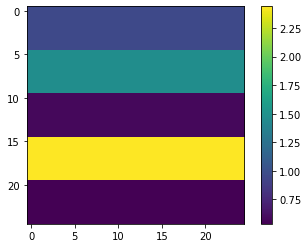

In [23]:
a = 0.5  # lower bound
b = 3  # upper bound
vec = a + (b - a) * torch.rand(5, requires_grad=True, dtype=torch.float64, device=device)

c = torch.zeros((25, 25), device='cuda:0', dtype=torch.float64)

for i in range(5):
    ones = torch.zeros((25, 25), device='cuda:0', dtype=torch.float64)
    ones[i*5:(i+1)*5] = 1
    c += ones * vec[i]


plt.imshow(c.cpu().detach().numpy())  # Display the matrix as an image
plt.colorbar()  # Optionally, display a colorbar
plt.show()

### Data assimilation Multi timestep - skipping layers

#### Generate Obs

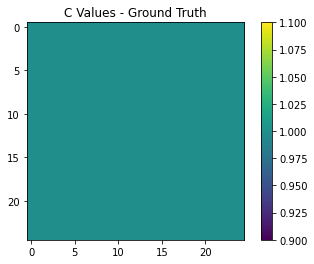

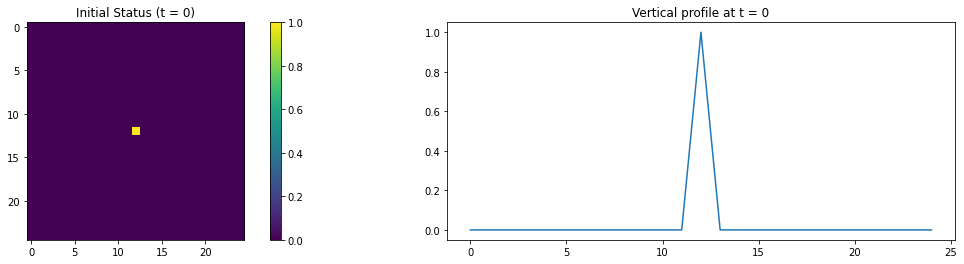

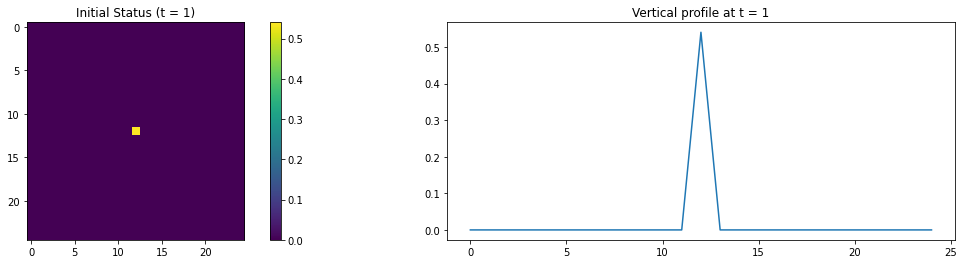

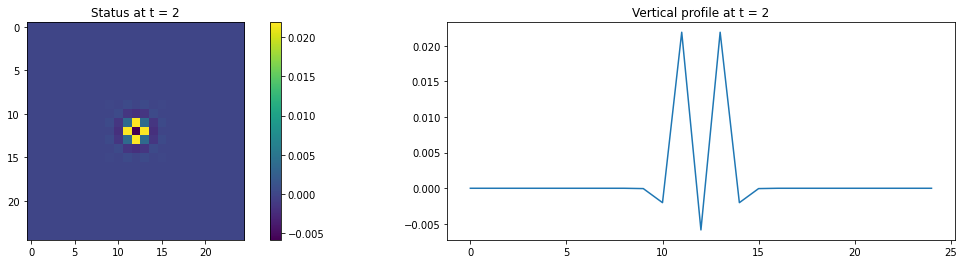

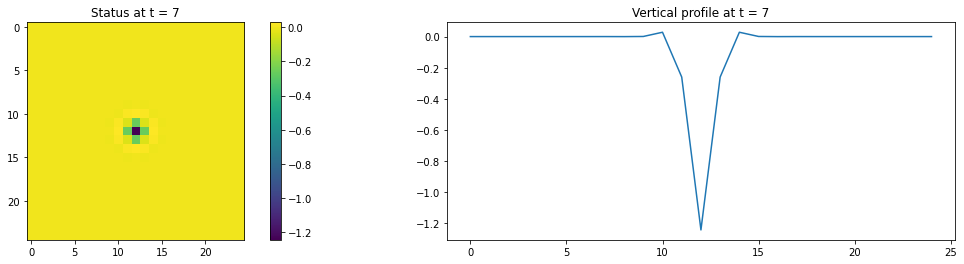

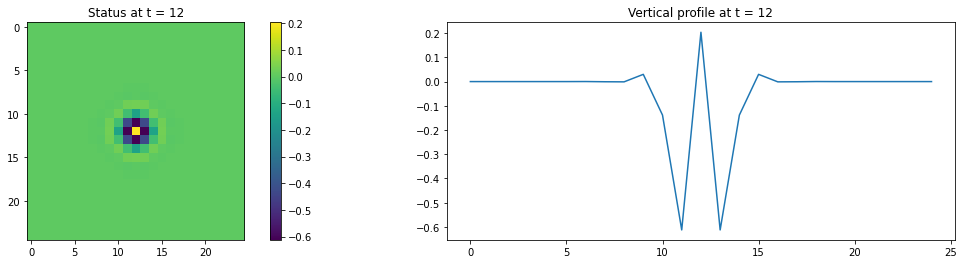

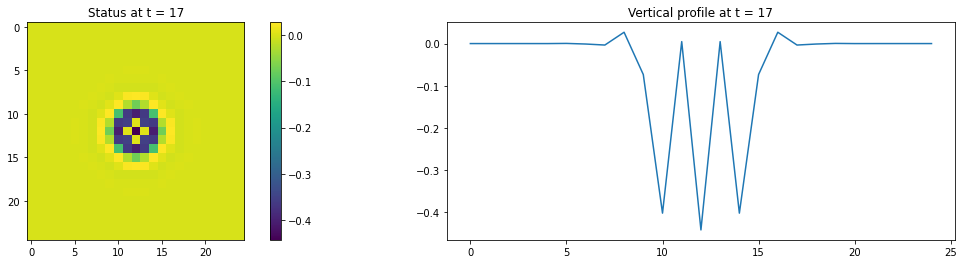

torch.Size([1, 22, 25, 25])


In [50]:
# Specify the size of the tensor
xysize = 25

timesteps = 20

# C values
c_tensor = torch.tensor(2.0, dtype=torch.float32, device=device, requires_grad=True)

# Plot C
plt.imshow(c_np, cmap='viridis')
plt.colorbar()
plt.title('C Values - Ground Truth')
plt.show()

# Create a meshgrid
x_values = np.linspace(0, 1, xysize)
y_values = np.linspace(0, 1, xysize)
x, y = np.meshgrid(x_values, y_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Equation parameters
sqrt2 = np.sqrt(2)
pi = np.pi

# Define the time tensors for t = 0, 1, and 2
time_tensor_t0 = torch.tensor(0, dtype=torch.float32)
time_tensor_t1 = torch.tensor(1, dtype=torch.float32)

# Function to create 2D Gaussian distribution
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
    return torch.exp(exponent)

# Parameters for Gaussian distributions
mu_x = 0.5
mu_y = 0.5
sigma_x = 0.005
sigma_y = 0.005

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y)
t1_values = gaussian2d(x_tensor, y_tensor, mu_x, mu_y, sigma_x, sigma_y) * torch.cos(time_tensor_t1)

# Stack the tensors along a new dimension to create 3D tensors
status_t0 = t0_values
status_t1 = t1_values

# Assume xysize, filter, and status_t0 are already defined
xysize = 25  # Replace with your actual value
filter_weight = filter.view(1, 1, filter.shape[0], filter.shape[1]).to(device)  # Assuming filter is a 2D filter

mymodel_multi = AI4WaveNeuralNetwork_Multi_Skipping(xysize, filter_weight)

status_t0_tensor = status_t0.view(1, 1, xysize, xysize).to(device)

# Perform a forward pass using AI4WaveNeuralNetwork
status_t1_tensor = status_t1.view(1, 1, xysize, xysize).to(device)

# Initial Status (t = 0)
fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# Plot the image on the first subplot
im = axs[0].imshow(status_t0.cpu().detach().numpy(), cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title("Initial Status (t = 0)")

# Plot the vertical profile on the second subplot
vertical_profile = status_t0.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
axs[1].plot(vertical_profile)
axs[1].set_title("Vertical profile at t = 0")

plt.show()

# Initial Status (t = 1)
fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

# Plot the image on the first subplot
im = axs[0].imshow(status_t1.cpu().detach().numpy(), cmap='viridis')
fig.colorbar(im, ax=axs[0])
axs[0].set_title("Initial Status (t = 1)")

# Plot the vertical profile on the second subplot
vertical_profile = status_t1.cpu().detach().numpy()[xysize//2, :]  # Take the middle row
axs[1].plot(vertical_profile)
axs[1].set_title("Vertical profile at t = 1")

plt.show()

output_tensor_obs = mymodel_multi(status_t1_tensor, status_t0_tensor, c_tensor, sigma2, nsteps = timesteps)

for i in range(timesteps):
    if (i) % 5 == 0:
        fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # Create 2 subplots side by side

        # Plot the image on the first subplot
        im = axs[0].imshow(output_tensor_obs.cpu().detach().numpy()[0][i+2], cmap='viridis')
        fig.colorbar(im, ax=axs[0])
        axs[0].set_title(f"Status at t = {i+2}")

        # Plot the vertical profile on the second subplot
        vertical_profile = output_tensor_obs.cpu().detach().numpy()[0][i+2][xysize//2, :]  # Take the middle row
        axs[1].plot(vertical_profile)
        axs[1].set_title(f"Vertical profile at t = {i+2}")

        plt.show()

print(output_tensor_obs.shape)

In [51]:
Status_List_stacked_obs = output_tensor_obs.squeeze(0)
print(Status_List_stacked_obs.shape)

torch.Size([22, 25, 25])


#### Place sensors

In [95]:
status_t0_np = status_t0.cpu().numpy() if isinstance(status_t0, torch.Tensor) else status_t0

# Set a seed for reproducibility
np.random.seed(42)

# Create an array of all indices
all_indices = np.arange(status_t0_np.size)

# Number of points to randomly select
num_points_to_select = 10

x_indices = np.linspace(0, xysize-1, num_points_to_select, dtype=int)
y_indices = np.linspace(0, xysize-1, num_points_to_select, dtype=int)

# x_selected, y_selected = np.meshgrid(x_indices, y_indices, indexing='ij')

# Combine x and y indices into a tuple
selected_indices = (x_indices, y_indices)

# Print the selected indices
print("Selected Indices:")
print(selected_indices)

Selected Indices:
(array([ 0,  2,  5,  8, 10, 13, 16, 18, 21, 24]), array([ 0,  2,  5,  8, 10, 13, 16, 18, 21, 24]))


In [96]:
print(selected_indices[0].shape)

(10,)


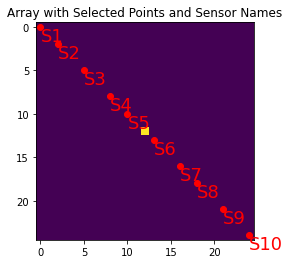

In [97]:
sensor_names = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10"]

# Visualize the array and selected points
plt.imshow(status_t0.cpu(), interpolation='none')

# Plot selected points as red dots
plt.scatter(selected_indices[0], selected_indices[1], color='red', marker='o')

# Annotate each point with the corresponding sensor name
for i, name in enumerate(sensor_names):
    plt.text(selected_indices[0][i], selected_indices[1][i], name, color='red', fontsize=18, ha='left', va='top')

plt.title('Array with Selected Points and Sensor Names')
plt.show()

#### Calculate data mismatch after forward stepping

In [82]:

# consider sensors
# Obs_sensor_3d_array = Status_List_stacked_forward1.clone()

# # Extract indices from the selected_indices tuple
# x_indices, y_indices = selected_indices

# # Iterate through the sensors and update the values in the original array
# for sensor_index in range(len(x_indices)):
#     x_index = x_indices[sensor_index]
#     y_index = y_indices[sensor_index]

#     # Update the values with the synthetic_observational_data
#     # DF_3d_array[:, x_index, y_index] = (Status_List_stacked_obs[:, x_index, y_index] - Status_List_stacked_forward1[:, x_index, y_index]) * 2
#     Obs_sensor_3d_array[:, x_index, y_index] = Status_List_stacked_obs[:, x_index, y_index]
    

# consider the whole domain to calculate loss
Obs_sensor_3d_array = Status_List_stacked_obs.clone()

print(Obs_sensor_3d_array.shape)

torch.Size([22, 25, 25])


#### Optimise C

In [37]:
# Define the MSE loss function
mse_loss = nn.MSELoss()

In [44]:
import wandb

wandb.login(key='ed9a26d8df2732c6312ef9b0f0f115814934ca07')


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/dg321/.netrc
2024-02-19 14:56:38.780792: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


c_value,█▇▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
c_value,1.00004
loss,0.0


2024-02-19 15:35:49.376004: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


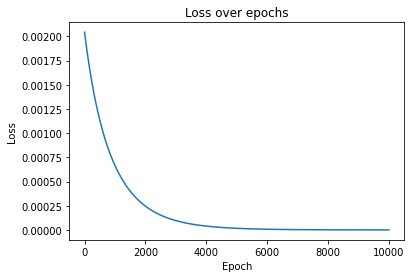

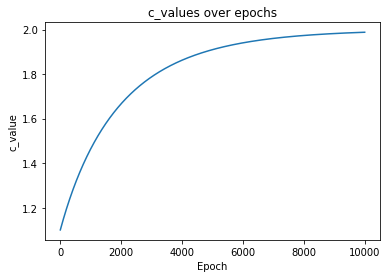

In [52]:
# Start a new run
run = wandb.init(project="wave eqn")

# C guess
c_forward1 = torch.tensor(1.1, dtype=torch.float32, device=device, requires_grad=True)

c_values = [c_forward1.item()]
lr = 0.1
optimizer = torch.optim.SGD([c_forward1], lr)

losses = []
epochs = 10000

for n in range(epochs):
    optimizer.zero_grad()
    output_tensor_forward1 = mymodel_multi(status_t1_tensor, status_t0_tensor, c_forward1, sigma2, nsteps = timesteps)
    Status_List_stacked_forward1 = output_tensor_forward1.squeeze(0)

    # consider the whole domain to calculate loss
    Obs_sensor_3d_array = Status_List_stacked_obs.clone()
    loss = mse_loss(Status_List_stacked_forward1, Obs_sensor_3d_array)

    # Backward pass to calculate gradients
    loss.backward(retain_graph=True)

    losses.append(loss.item())

    # optimize C
    # c_forward1 -= lr * c_forward1.grad
    optimizer.step()
    c_values.append(c_forward1.item())

    # Log the loss and c_value to wandb
    wandb.log({"loss": loss.item(), "c_value": c_forward1.item()})


    # # If the current epoch number is a multiple of 10, plot c_forward1
    # if n % 10 == 0:
    #     print(c_forward1)

plt.figure()
plt.plot(losses)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(c_values)
plt.title('c_values over epochs')
plt.xlabel('Epoch')
plt.ylabel('c_value')
plt.show()


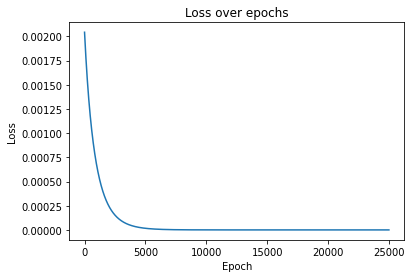

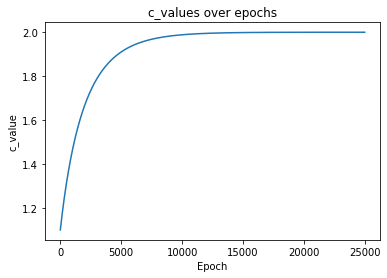

In [62]:
epochs = 3000

for n in range(epochs):
    optimizer.zero_grad()
    output_tensor_forward1 = mymodel_multi(status_t1_tensor, status_t0_tensor, c_forward1, sigma2, nsteps = timesteps)
    Status_List_stacked_forward1 = output_tensor_forward1.squeeze(0)

    # consider the whole domain to calculate loss
    Obs_sensor_3d_array = Status_List_stacked_obs.clone()
    loss = mse_loss(Status_List_stacked_forward1, Obs_sensor_3d_array)

    # Backward pass to calculate gradients
    loss.backward(retain_graph=True)

    losses.append(loss.item())

    # optimize C
    # c_forward1 -= lr * c_forward1.grad
    optimizer.step()
    c_values.append(c_forward1.item())

    # Log the loss and c_value to wandb
    wandb.log({"loss": loss.item(), "c_value": c_forward1.item()})


    # # If the current epoch number is a multiple of 10, plot c_forward1
    # if n % 10 == 0:
    #     print(c_forward1)

plt.figure()
plt.plot(losses)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(c_values)
plt.title('c_values over epochs')
plt.xlabel('Epoch')
plt.ylabel('c_value')
plt.show()

In [63]:
print(c_forward1)
print(losses[-1])

tensor(1.9999, device='cuda:0', requires_grad=True)
4.4333450105460415e-11


In [55]:
print(c_forward1)
print(losses[-1])

tensor(1.9965, device='cuda:0', requires_grad=True)
2.444367019904803e-08
